In [ ]:
# @Author :fiv

[TOC]

<div STYLE="page-break-after: always;"></div>

# 1、实验目的
 本章实验的主要目的是掌握语音处理相关知识点，了解语音处理相关基础知识，了解语音信号
分析的一般流程，掌握 MFCC 提取过程。
 
# 2、音频录制
通过 Python 工具库 pyaudio，调用本地麦克风阵列实现音频的录制。 

In [1]:
import pyaudio
import wave
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')


def record(wave_out_path: str, record_second: float):
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 2
    RATE = 44100
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)
    wf = wave.open(wave_out_path, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    for _ in tqdm(range(0, int(RATE / CHUNK * record_second))):
        data = stream.read(CHUNK)
        wf.writeframes(data)
    stream.stop_stream()
    stream.close()
    p.terminate()
    wf.close()

In [2]:
output = "./output/record.wav"
import os

if not os.path.exists(os.path.dirname(output)):
    os.makedirs(os.path.dirname(output))
record(output, 5)

100%|██████████| 215/215 [00:04<00:00, 43.11it/s]


In [3]:
import IPython

IPython.display.Audio(output)


# 3、语言信号预处理

## 3.1 显示频谱 

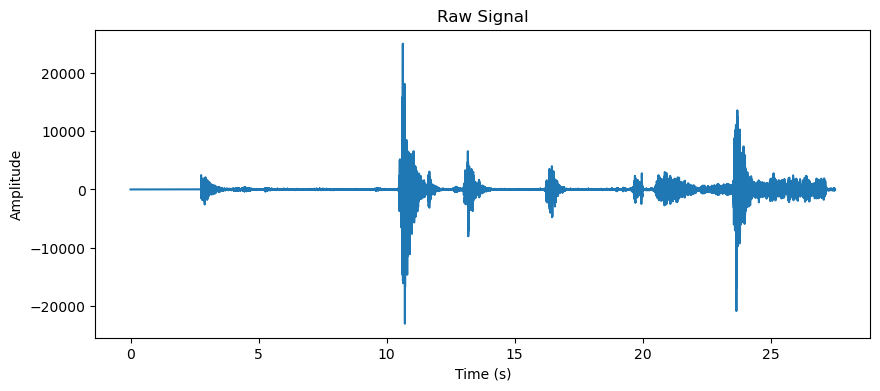

In [4]:
from pathlib import Path
from HTKFeat import MFCC_HTK
import matplotlib.pyplot as plt
import numpy as np


def display_spec(filepath: Path):
    assert filepath.exists()
    mfcc = MFCC_HTK()
    signal = mfcc.load_raw_signal(filepath)
    signal = signal[100:]  # remove the noise
    sig_len = signal.size / 16000

    plt.figure(figsize=(10, 4))
    t = np.linspace(0, sig_len, signal.size)
    plt.plot(t, signal)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Raw Signal')
    plt.show()


display_spec(Path(output))

## 3.2 分帧

In [5]:
import numpy as np


def frame(x, lframe, mframe):
    """
    :param x: 输入信号
    :param lframe: 帧长
    :param mframe: 帧移
    :return: 分帧后的信号
    """
    N = len(x)
    fn = (N - lframe) // mframe + 1
    return np.array([x[i * mframe:i * mframe + lframe] for i in range(fn)])


frame([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 3, 3)

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

## 3.3 加窗

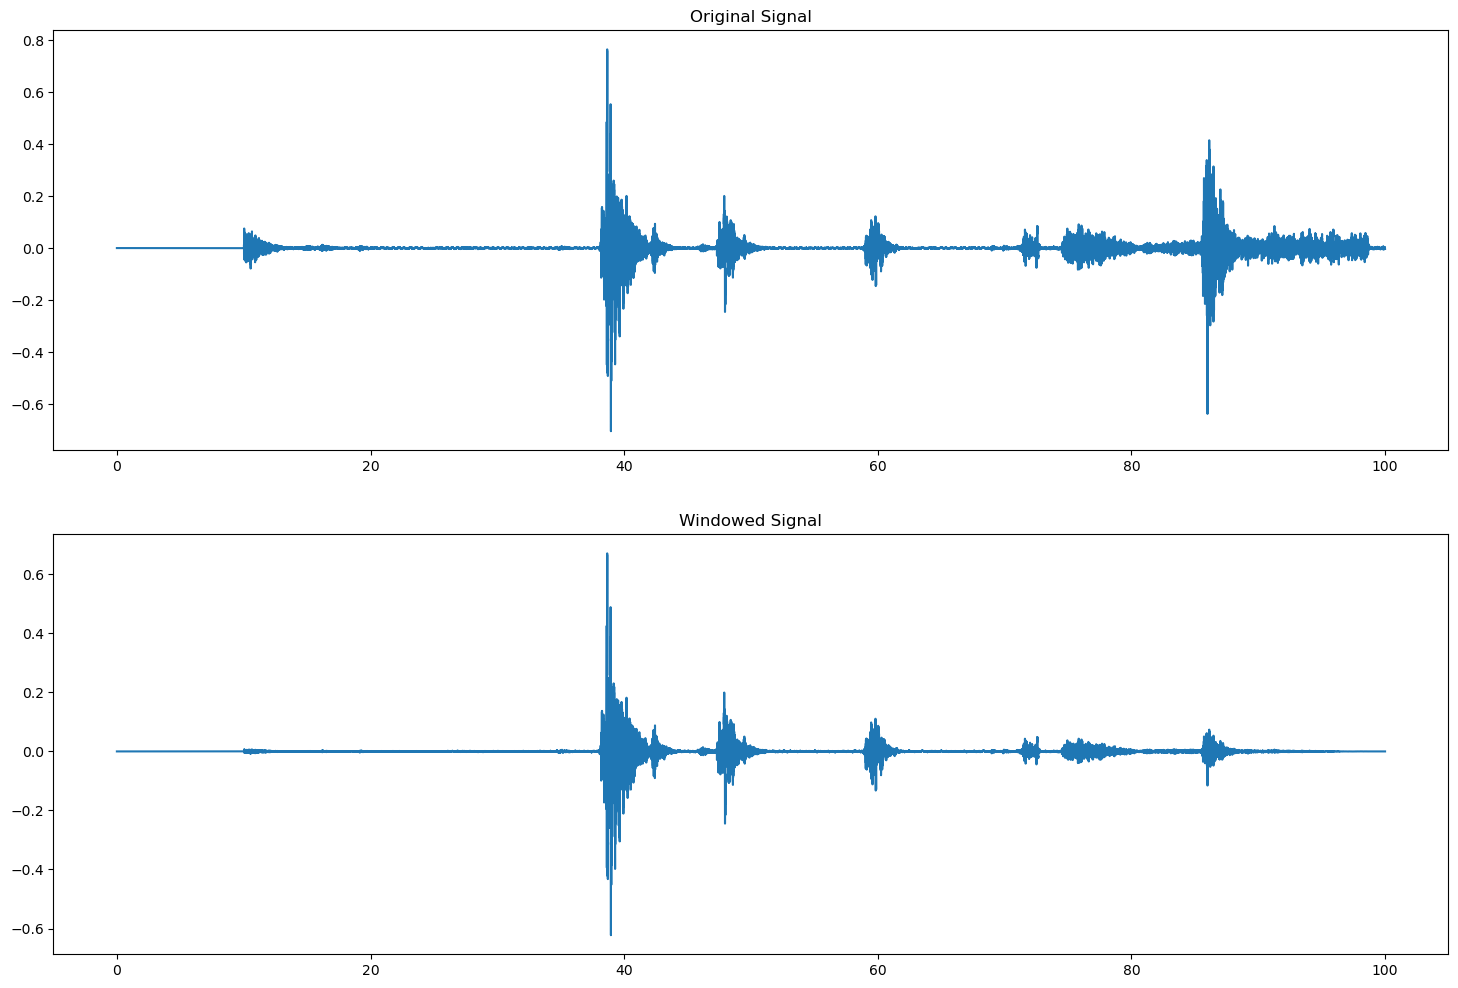

In [6]:
import librosa


def win_frame(frame, win_type):
    """
    :param frame: 一帧信号
    :param win_type: 窗函数类型
    :return: 加窗后的信号
    """
    if win_type == "hanning":
        return frame * np.hanning(frame.size)
    elif win_type == "hamming":
        return frame * np.hamming(frame.size)
    elif win_type == "blackman":
        return frame * np.blackman(frame.size)
    elif win_type == "bartlett":
        return frame * np.bartlett(frame.size)
    else:
        raise ValueError("Unsupported window type")


def win_signal(signal, win_type):
    """
    :param signal: 信号
    :param win_type: 窗函数类型
    :return: 加窗后的信号
    """
    frames = frame(signal, 160, 80)
    win_frames = np.zeros(frames.shape)
    for i in range(frames.shape[0]):
        win_frames[i] = win_frame(frames[i], win_type)
    return win_frames


signal, _ = librosa.load(output, sr=None)
signal_win = win_frame(signal, "hanning")
plt.figure(figsize=(18, 12))
t = np.linspace(0, 100, signal.size)
plt.subplot(2, 1, 1)
plt.plot(t, signal)
plt.title('Original Signal')
plt.subplot(2, 1, 2)
plt.plot(t, signal_win)
plt.title('Windowed Signal')

plt.show()


# 4、语音信号分析

## 4.1 快速傅里叶变换

(0.0, 256.0)

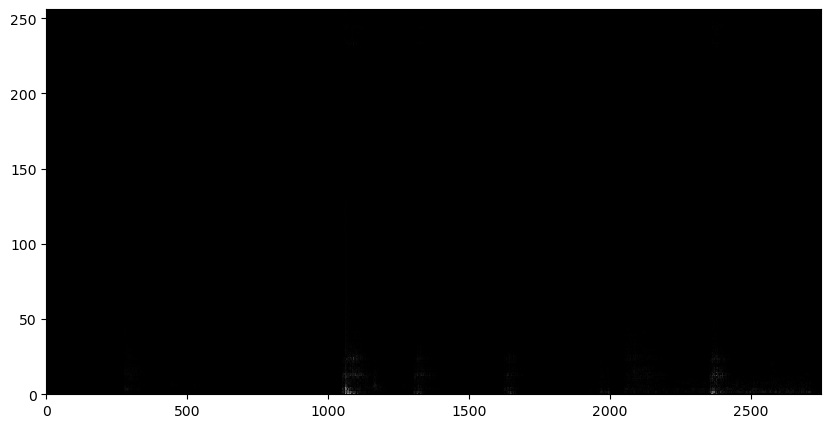

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from HTKFeat import MFCC_HTK

# 配置数据路径
data_path = output
mfcc = MFCC_HTK()
win_shift = 160
win_len = 400
signal = mfcc.load_raw_signal(data_path)
signal = signal[100:]
sig_len = len(signal)
win_num = np.floor((sig_len - win_len) / win_shift).astype('int') + 1
wins = []
for w in range(win_num):
    #t 每个窗的开始和结束
    s = w * win_shift
    e = s + win_len

    win = signal[s:e].copy()

    wins.append(win)

wins = np.asarray(wins)
fft_len = (2 ** (np.floor(np.log2(win_len)) + 1)).astype('int')
ffts = []
for win in wins:
    win = np.abs(np.fft.rfft(win, n=fft_len)[:-1])
    ffts.append(win)
ffts = np.asarray(ffts)
plt.figure(figsize=(10, 5))
plt.pcolormesh(ffts.T, cmap='gray')
plt.xlim(0, win_num)
plt.ylim(0, fft_len / 2)

##  4.2 梅尔频谱倒频系数

Text(0, 0.5, 'Mel')

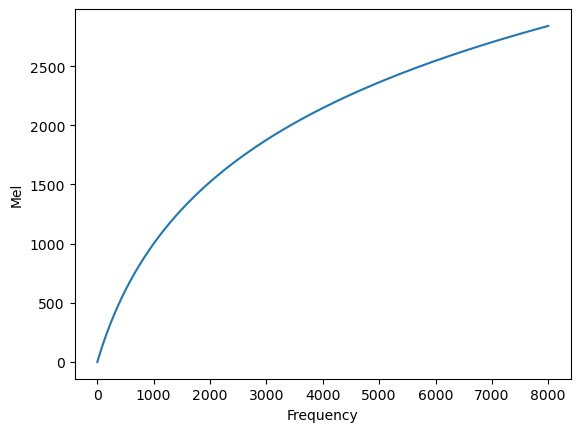

In [8]:
freq2mel = lambda freq: 1127 * (np.log(1 + ((freq) / 700.0)))
f = np.linspace(0, 8000, 1000)
m = freq2mel(f)
plt.plot(f, m)
plt.xlabel('Frequency')
plt.ylabel('Mel')

## 4.3 滤波器

### 4.3.1 三角滤波器

(0.0, 256.0)

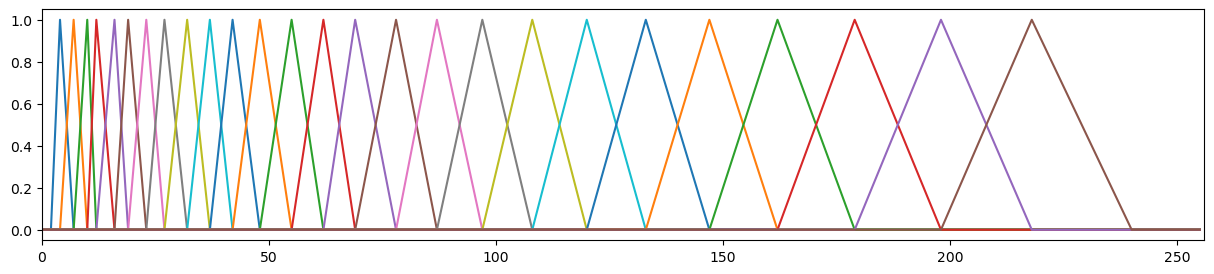

In [9]:
mfcc.create_filter(26)
plt.figure(figsize=(15, 3))
for f in mfcc.filter_mat.T:
    plt.plot(f)
plt.xlim(0, 256)

### 4.3.2 快速傅里叶变换的结果与滤波器乘积

(0.0, 26.0)

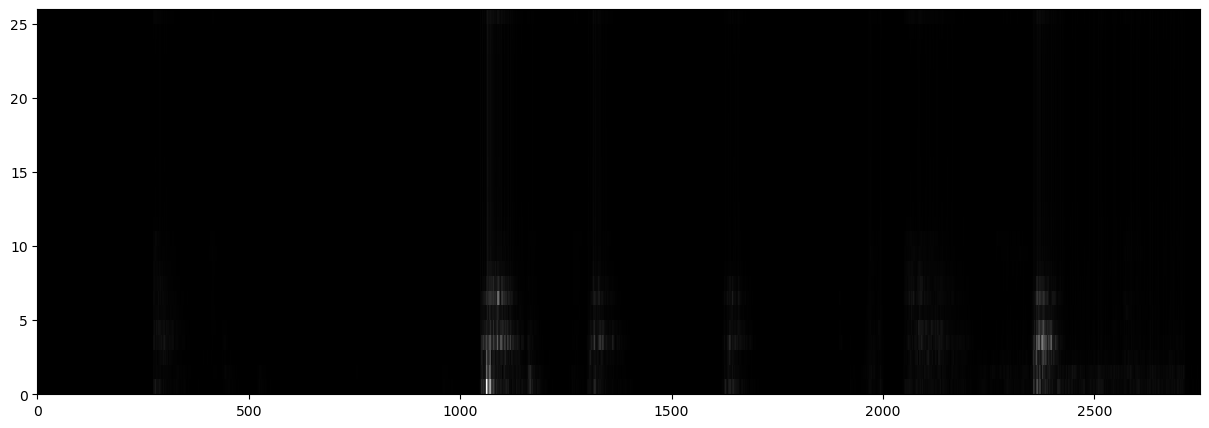

In [10]:
melspec = []
for f in ffts:
    m = np.dot(f, mfcc.filter_mat)
    melspec.append(m)
melspec = np.asarray(melspec)
plt.figure(figsize=(15, 5))
plt.pcolormesh(melspec.T, cmap='gray')
plt.xlim(0, win_num)
plt.ylim(0, 26)

### 4.3.3 放大数据中的细节同时衰减高光

(0.0, 26.0)

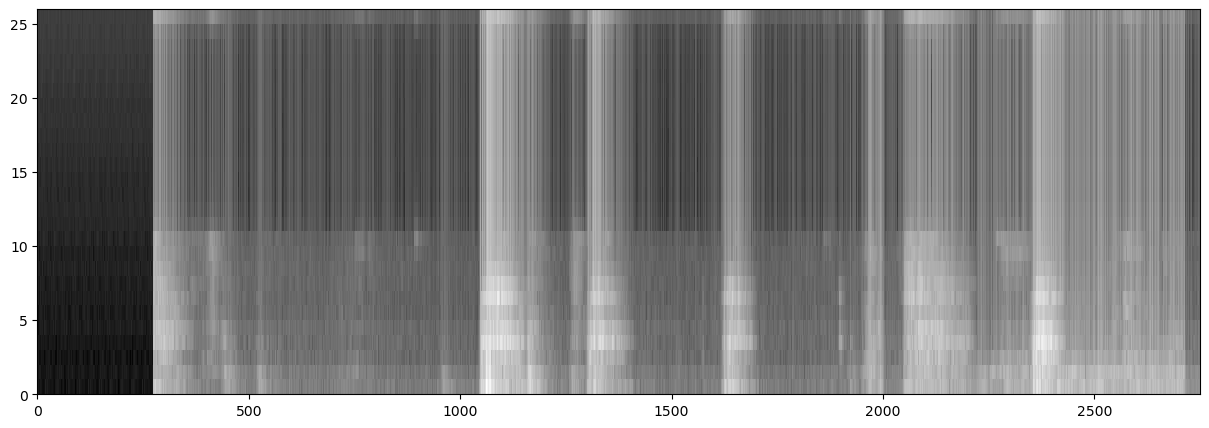

In [11]:
mels = np.log(melspec)
plt.figure(figsize=(15, 5))
plt.pcolormesh(mels.T, cmap='gray')
plt.xlim(0, win_num)
plt.ylim(0, 26)

##  4.4 离散余弦变换

###  4.4.1 离散余弦变换效果

Text(0, 0.5, 'MFCCs')

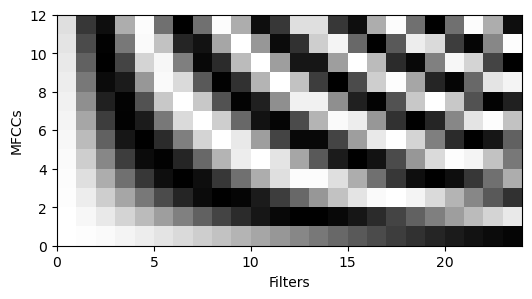

In [12]:
filter_num = 26
mfcc_num = 12
dct_base = np.zeros((filter_num, mfcc_num))
for m in range(mfcc_num):
    dct_base[:, m] = np.cos((m + 1) * np.pi / filter_num * (np.arange(filter_num) + 0.5))

plt.figure(figsize=(6, 3))
plt.pcolormesh(dct_base.T, cmap='gray')
plt.xlim(0, 24)
plt.ylim(0, 12)
plt.xlabel('Filters')
plt.ylabel('MFCCs')

### 4.4.2 获得 MFCC

(0.0, 12.0)

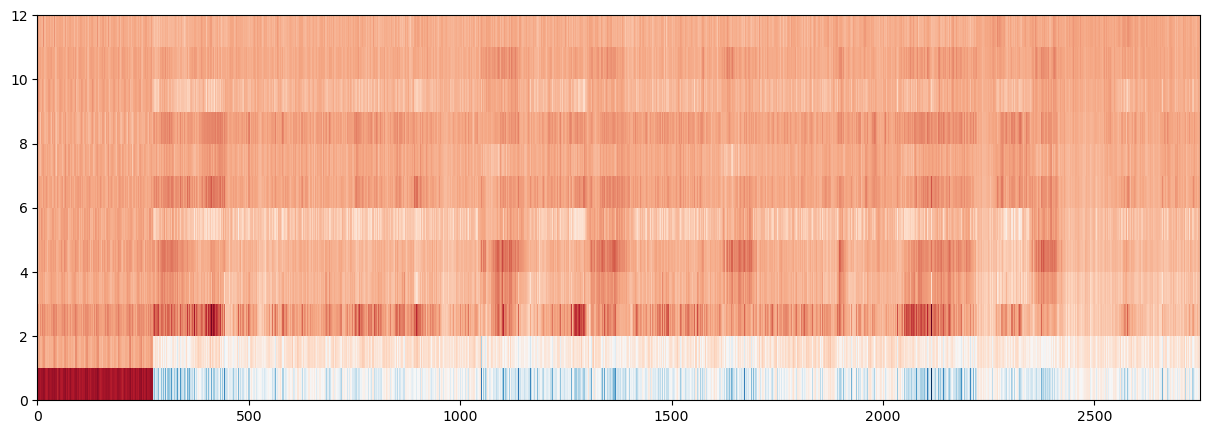

In [13]:
filter_num = 26
mfcc_num = 12
mfccs = []
for m in mels:
    c = np.dot(m, dct_base)
    mfccs.append(c)
mfccs = np.asarray(mfccs)
plt.figure(figsize=(15, 5))
plt.pcolormesh(mfccs.T, cmap='RdBu')  #cmap:RdBu,Oranges,YlGn,OrRd,gray，...
plt.xlim(0, win_num)
plt.ylim(0, mfcc_num)

### 4.4.3 将 MFCC 归一化

In [14]:
mfnorm = np.sqrt(2.0 / filter_num)
mfccs *= mfnorm
mfccs

array([[-3.22664938,  0.40384013, -0.13329305, ..., -0.19222353,
        -0.23330833, -0.03005451],
       [-3.53283117, -0.03891852, -0.33337992, ..., -0.16141628,
        -0.1812898 , -0.14193339],
       [-3.29469986,  0.06124531, -0.28099348, ..., -0.54705533,
        -0.10940433, -0.15399701],
       ...,
       [ 4.77224613,  3.02368142, -0.10629264, ...,  0.77820428,
         0.23112638,  0.13293376],
       [ 2.89844857,  1.92327477,  0.70960444, ...,  0.33013057,
         0.18301702,  0.1427248 ],
       [ 2.82296666,  1.93387417,  0.75514422, ...,  0.07622445,
        -0.01173519,  0.04466178]])

##  4.5 对比倒频谱能量与原始能量 

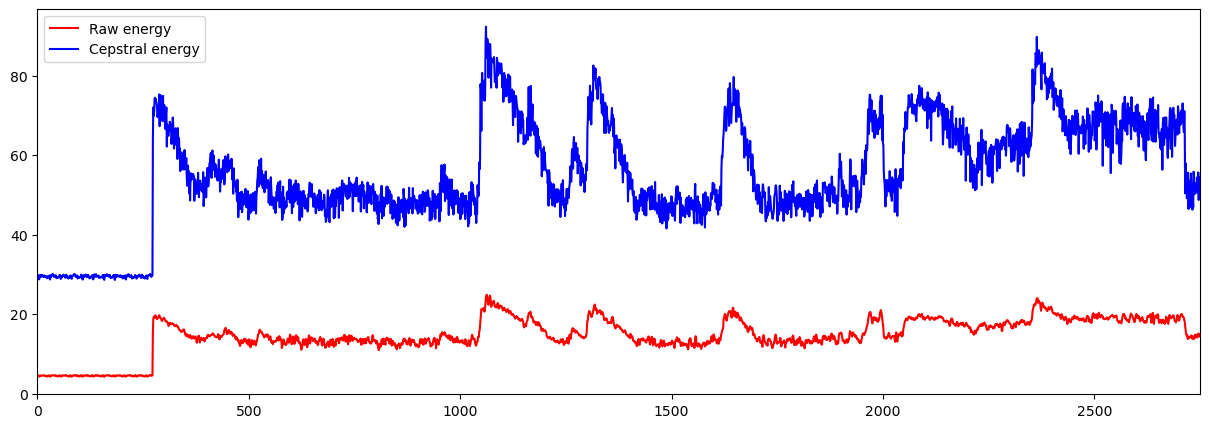

In [15]:
raw_energy = []
for win in wins:
    raw_energy.append(np.log(np.sum(win ** 2)))
raw_energy = np.asarray(raw_energy)
ceps_energy = []
for m in mels:
    ceps_energy.append(np.sum(m) * mfnorm)
ceps_energy = np.asarray(ceps_energy)

plt.figure(figsize=(15, 5))
plt.plot(raw_energy, 'r', label='Raw energy')
plt.plot(ceps_energy, 'b', label='Cepstral energy')  #倒频谱能量
plt.xlim(0, win_num)
plt.legend()

# 附

(10, 5)


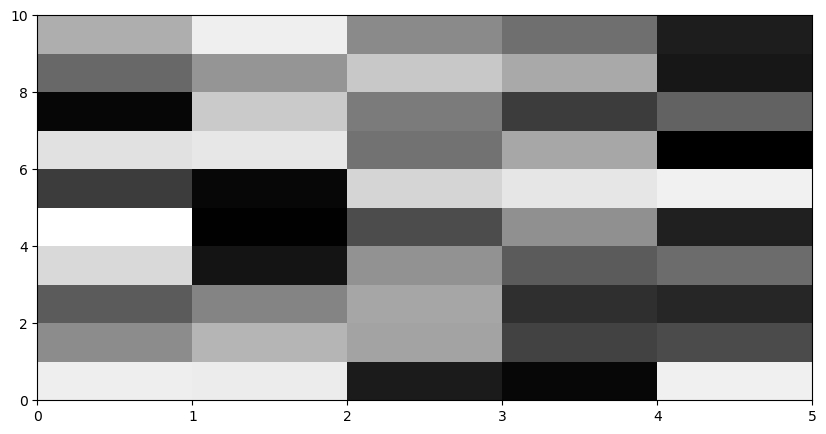

In [17]:
import numpy as np
import matplotlib.pyplot as plt

data = np.random.rand(10, 5)
print(data.shape)
plt.figure(figsize=(10, 5))
plt.pcolormesh(data, cmap='gray')
plt.show()